In [23]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import numpy as np

path = '/home/gdholla1/projects/bias/data/hddm_fits'

def get_model(model):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

    # Prepare data
    data = df[['cue_validity', 'rt', 'correct', 'difficulty', 'subj_idx']]
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    regs, free_pars = model.split('_')

    if regs == 'drift':
        z_reg = {'model': 'z ~ 0', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}
    elif regs == 'startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
    elif regs == 'both':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}

    reg_descr = [z_reg, v_reg]

    if free_pars == 'sv':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])
    elif free_pars == 'sz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sz'), bias=True, group_only_regressors=False, group_only_nodes=['sz'])
    elif free_pars == 'svsz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'])
    elif free_pars == 'all':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])


    return hddm_model

In [24]:
import glob
import re

import pickle as pkl

In [25]:
# models = ['drift_all', 'drift_sv', 'drift_sz', 'drift_svsz',
#           'startpoint_all', 'startpoint_sv', 'startpoint_sz', 'startpoint_svsz',
#           'both_all', 'both_sv', 'both_sz', 'both_svsz']

# models = ['drift_sv', 'drift_sz', 'drift_svsz',
#           'startpoint_sv', 'startpoint_sz', 'startpoint_svsz',
#           'both_sz', 'both_svsz']


models = ['drift_sv', 'startpoint_sv', 'startpoint_sv', 'both_sv']

r = []

for model in models:
    print model
    hddm_model = get_model(model)
    reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])
            
    r.append({'model':model, 'dic':hddm_model.dic})

drift_sv


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
[]
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']
startpoint_sv
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
startpoint_sv
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']
both_sv
Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [26]:
pandas.DataFrame(r).sort('dic')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,dic,model
3,8824.962028,both_sv
0,8895.169402,drift_sv
1,9029.506058,startpoint_sv
2,9029.506058,startpoint_sv


In [89]:

model = 'startpoint_svsz'
hddm_model = get_model(model)
reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_model.load_db(fns[0], db='pickle')

for fn in fns[1:]:
    traces = pkl.load(open(fn))    
    for node in hddm_model.get_stochastics().node:
        node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']


In [95]:
traces = hddm_model.get_traces()


r = []
for subj_idx in np.arange(1, 20):
    r.append({'subj_idx':subj_idx, 'z_cue_coding':traces['z_cue_coding_subj.%d' % subj_idx].mean()})
    
pars_startpoint = pandas.DataFrame(r)

In [4]:

model = 'both_svsz'
hddm_model = get_model(model)
reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

hddm_model.load_db(fns[0], db='pickle')

for fn in fns[1:]:
    traces = pkl.load(open(fn))    
    for node in hddm_model.get_stochastics().node:
        node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [5]:
traces = hddm_model.get_traces()

In [6]:
value_vars = ['v_cue_coding_subj.%d' % i for i in np.arange(1, 20)]  +  ['z_cue_coding_subj.%d' % i for i in np.arange(1, 20)]

In [7]:
tmp = pandas.melt(traces, value_vars=value_vars)

tmp['subj_idx'] = tmp.variable.map(lambda x: x.split('.')[1])
tmp['variable'] = tmp.variable.map(lambda x: x.split('.')[0])

In [8]:
tmp.shape

(10830000, 3)

In [10]:
sns.set_context('poster')
sns.set_style('whitegrid')

In [18]:
tmp['subj_idx'] = tmp['subj_idx'].apply(lambda x: 'S%s' % x)

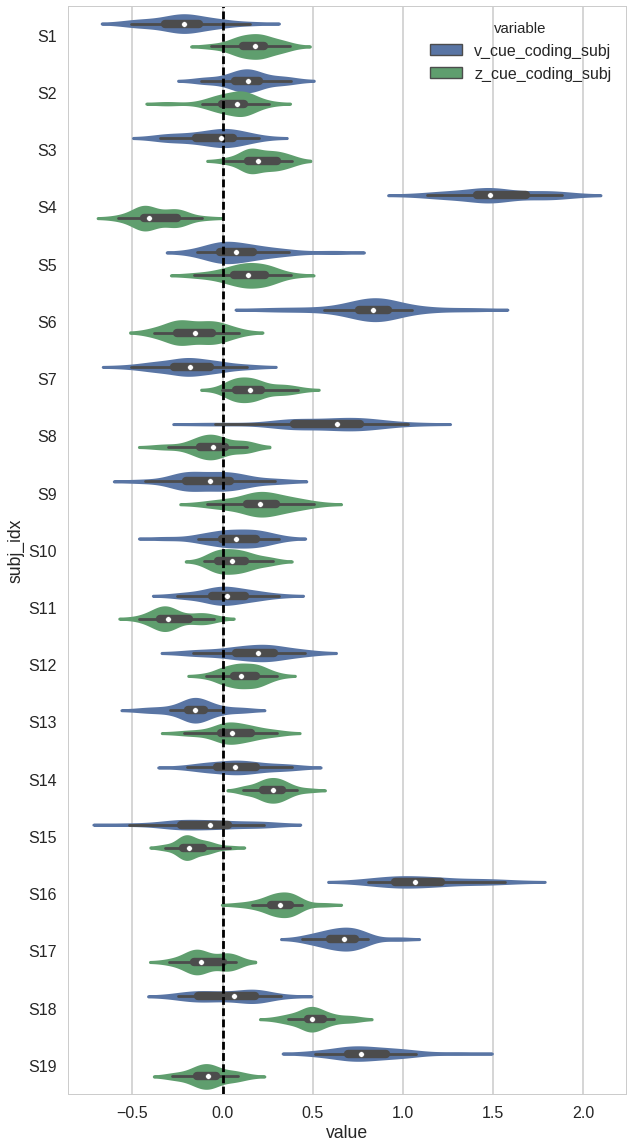

In [20]:
sns.violinplot('value', 'subj_idx', 'variable', tmp.iloc[::10000])

plt.axvline(0, c='k', ls='--')

plt.gcf().set_size_inches(10, 20)

In [98]:
r = []
for subj_idx in np.arange(1, 20):
    r.append({'subj_idx':subj_idx, 'z_cue_coding':traces['z_cue_coding_subj.%d' % subj_idx].mean(),
             'v_cue_coding':traces['v_cue_coding_subj.%d' % subj_idx].mean()})
    
pars_both = pandas.DataFrame(r)

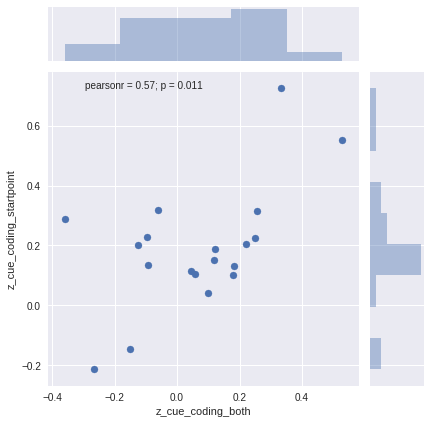

In [106]:
pars_merged = pars_both.merge(pars_startpoint, on='subj_idx', suffixes=('_both', '_startpoint'))

sns.jointplot('z_cue_coding_both', 'z_cue_coding_startpoint', pars_merged)

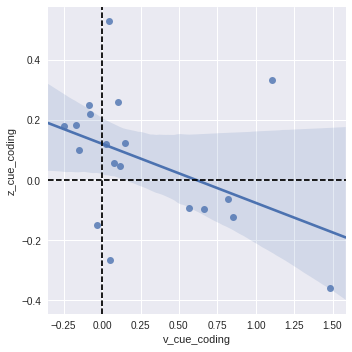

In [70]:
r = []

for i in np.arange(1, 20):
    r.append({'z_cue_coding':traces['z_cue_coding_subj.%d' % i].mean(),
              'v_cue_coding':traces['v_cue_coding_subj.%d' % i].mean(),
              'subj_idx':i})
sns.lmplot('v_cue_coding', 'z_cue_coding', pandas.DataFrame(r))

plt.axhline(0, c='k', ls='--')
plt.axvline(0, c='k', ls='--')

In [87]:
pandas.DataFrame(r).to_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')

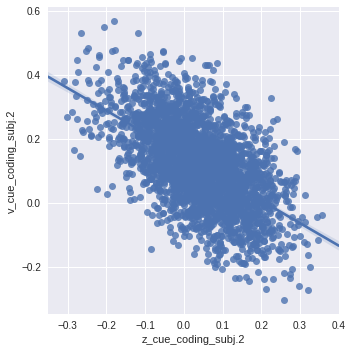

In [54]:
sns.lmplot('z_cue_coding_subj.2', 'v_cue_coding_subj.2', traces.iloc[::100])

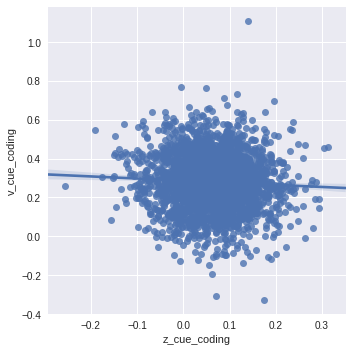

In [71]:
sns.lmplot('z_cue_coding', 'v_cue_coding', traces.iloc[::100])

In [76]:
(traces['v_cue_coding'] > 0 ).mean()

0.97941052631578951

In [75]:
(traces['z_cue_coding'] > 0 ).mean()

0.84255438596491228

In [78]:
traces.head()

,a,a_std,a_subj.1,a_subj.10,a_subj.11,a_subj.12,a_subj.13,a_subj.14,a_subj.15,a_subj.16,...,z_cue_coding_subj.18,z_cue_coding_subj.19,z_cue_coding_subj.2,z_cue_coding_subj.3,z_cue_coding_subj.4,z_cue_coding_subj.5,z_cue_coding_subj.6,z_cue_coding_subj.7,z_cue_coding_subj.8,z_cue_coding_subj.9
0,1.628539,0.200966,1.395814,1.651986,1.893517,1.517720,1.936392,1.703106,1.492061,1.552807,...,0.309083,0.125707,0.199603,0.208370,-0.115610,0.275046,0.052563,0.405628,0.111264,0.288025
1,1.675048,0.225506,1.367792,1.615614,1.932333,1.515571,1.961686,1.829172,1.551076,1.545703,...,0.404281,0.157781,0.185470,0.208201,-0.173184,0.123505,-0.123040,0.340285,-0.193337,0.233244
2,1.662929,0.160475,1.407607,1.634860,1.920696,1.534393,2.019408,1.810978,1.473333,1.604061,...,0.405090,-0.120397,-0.003406,0.243746,-0.375842,0.261860,0.010384,0.326572,-0.159820,0.314631
3,1.562371,0.156713,1.350796,1.640777,1.955373,1.542767,1.806933,1.732628,1.467697,1.611212,...,0.454539,-0.063875,0.183027,-0.016512,-0.358681,0.181454,-0.106652,0.299076,-0.194044,0.261501
4,1.600442,0.142785,1.414555,1.685871,1.841388,1.540433,1.830177,1.676594,1.455100,1.549479,...,0.330170,-0.330835,0.068158,0.166433,-0.336218,0.361063,-0.125291,0.286916,0.055139,0.257452


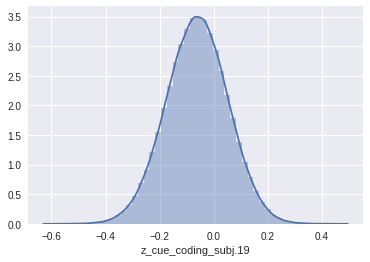

In [83]:
sns.distplot(traces['z_cue_coding_subj.19'])

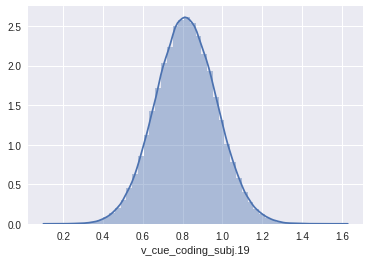

In [82]:
sns.distplot(traces['v_cue_coding_subj.19'])

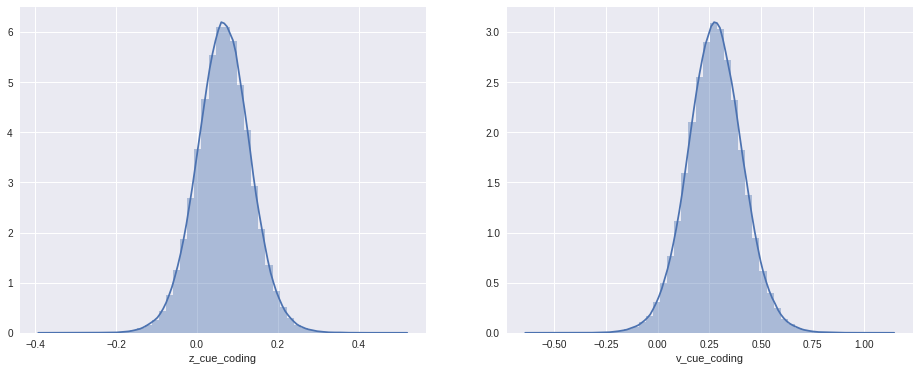

In [74]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(traces['z_cue_coding'])

plt.subplot(122)
sns.distplot(traces['v_cue_coding'])

In [19]:
model = 'both_sv'

In [ ]:
/home/gdholla1/projects/bias/data/hddm_fits/traces_bot

In [20]:
fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]
fns

[]

In [32]:
model = 'startpoint_sv'

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]']


In [34]:
/home/gdholla1/projects/bias/data/hddm_fits/traces_start_point

In [41]:
hddm_models[4].dic

9029.6115031329227

In [22]:
for i in np.arange(0, 12):
    models = ['drift_super', 'drift_errors_super', 'start_point_super', 'all_super', 'all_super_drift_bias_cue', 'all_super_drift_bias_stim']
    hemispheres = ['L', 'R']


    hemisphere_idx = i / len(models)
    model_idx = i % len(models)

    hemisphere = hemispheres[hemisphere_idx]
    model = models[model_idx]

    print i, hemisphere, model

0 L drift_super
1 L drift_errors_super
2 L start_point_super
3 L all_super
4 L all_super_drift_bias_cue
5 L all_super_drift_bias_stim
6 R drift_super
7 R drift_errors_super
8 R start_point_super
9 R all_super
10 R all_super_drift_bias_cue
11 R all_super_drift_bias_stim
